In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

# Add the parent directory to the Python path
parent_dir = os.path.abspath('../..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
# Import modules
import ddsp_textures.loss.functions
import ddsp_textures.auxiliar.filterbanks

# Import extra packages
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import torch

In [2]:
# Load audio to filter -----------------------------------
fire_path  = ".."+"/sounds/fire.wav"
water_path = ".."+"/sounds/water.wav"
sr = 44100
fire_audio, _  = librosa.load(fire_path, sr=sr)
water_audio, _ = librosa.load(water_path, sr=sr)
# Make list of segments for fire and water --------------
frame_size = 2**16
hop_size   = 2**16
fire_segments = []
water_segments = []
for i in range(0, len(fire_audio)-frame_size, hop_size):
    fire_segments.append(fire_audio[i:i+frame_size])
for i in range(0, len(water_audio)-frame_size, hop_size):
    water_segments.append(water_audio[i:i+frame_size])
# Initialize erb_bank and log_bank for statistics loss --
N_filterbank = 16
erb_bank = ddsp_textures.auxiliar.filterbanks.EqualRectangularBandwidth(frame_size, sr, N_filterbank, 20, sr // 2)
log_bank = ddsp_textures.auxiliar.filterbanks.Logarithmic(frame_size // 4, 11025, 6, 10, 11025 // 4)

In [3]:
#Testing Statistics functions --------------------------------------------------

fire_segment  = fire_segments[np.random.randint(len(fire_segments))]
water_segment = water_segments[np.random.randint(len(water_segments))]
fire_segment  = torch.tensor(fire_segment)
water_segment = torch.tensor(water_segment)
fire_stats  = ddsp_textures.loss.functions.statistics(fire_segment, N_filterbank, sr, erb_bank, log_bank)
water_stats = ddsp_textures.loss.functions.statistics(water_segment, N_filterbank, sr, erb_bank, log_bank)
print("Fire statistics:\n")
print("stats_1:\n", fire_stats[0])
print("stats_2:\n", fire_stats[1])
print("stats_3:\n", fire_stats[2])
print("stats_4:\n", fire_stats[3])
print("stats_5:\n", fire_stats[4])
print("Water statistics:\n")
print("stats_1:\n", water_stats[0])
print("stats_2:\n", water_stats[1])
print("stats_3:\n", water_stats[2])
print("stats_4:\n", water_stats[3])
print("stats_5:\n", water_stats[4])

Fire statistics:

stats_1:
 tensor([[1.8631, 0.4257, 0.0207, 0.0079],
        [1.5287, 0.3062, 0.0164, 0.0074],
        [0.6552, 0.3784, 0.0225, 0.0094],
        [0.3919, 0.4251, 0.0223, 0.0092],
        [0.2283, 0.4817, 0.0422, 0.0290],
        [0.1964, 0.8352, 0.1093, 0.1335],
        [0.1330, 2.4128, 0.2420, 0.4564],
        [0.1013, 4.1178, 0.3152, 0.7214],
        [0.0742, 4.7290, 0.2972, 0.6546],
        [0.0784, 3.0026, 0.2780, 0.5528],
        [0.0634, 3.6733, 0.2859, 0.6168],
        [0.1651, 0.8343, 0.1225, 0.1819],
        [0.1105, 1.3064, 0.1953, 0.3346],
        [0.3348, 0.5526, 0.0278, 0.0145],
        [0.1948, 0.5500, 0.0484, 0.0363],
        [1.0598, 0.5722, 0.0195, 0.0073]])
stats_2:
 tensor([0.8885, 0.2919, 0.7449, 0.2248, 0.4823, 0.0964, 0.1246, 0.0419, 0.1923,
        0.0384, 0.6494, 0.1179, 0.9015, 0.2424, 0.9755, 0.6439, 0.5512, 0.4373,
        0.3580, 0.1560, 0.0874, 0.0406, 0.1447, 0.0419, 0.5102, 0.2283, 0.7141,
        0.5187, 0.7777, 0.1746, 0.5664, 0.0784, 0

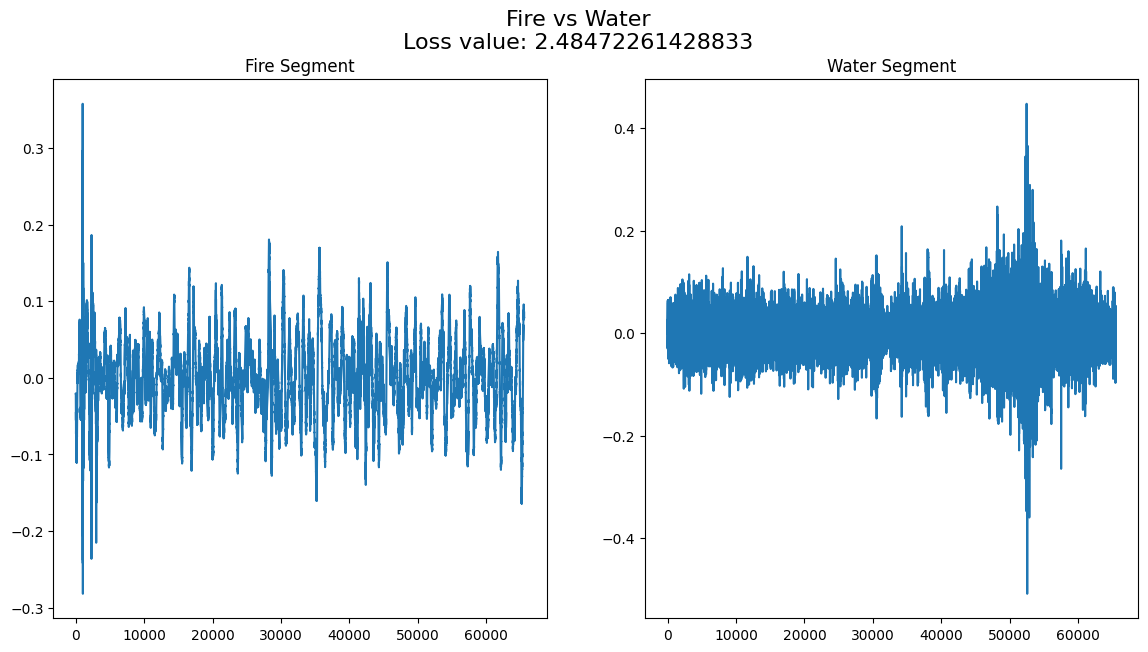

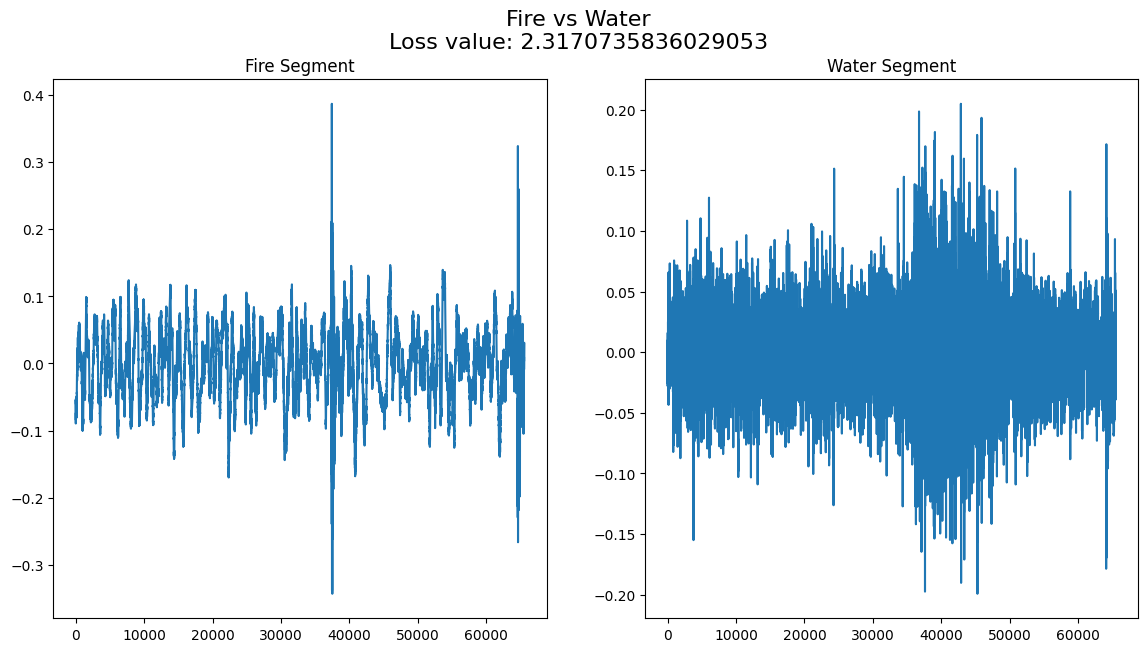

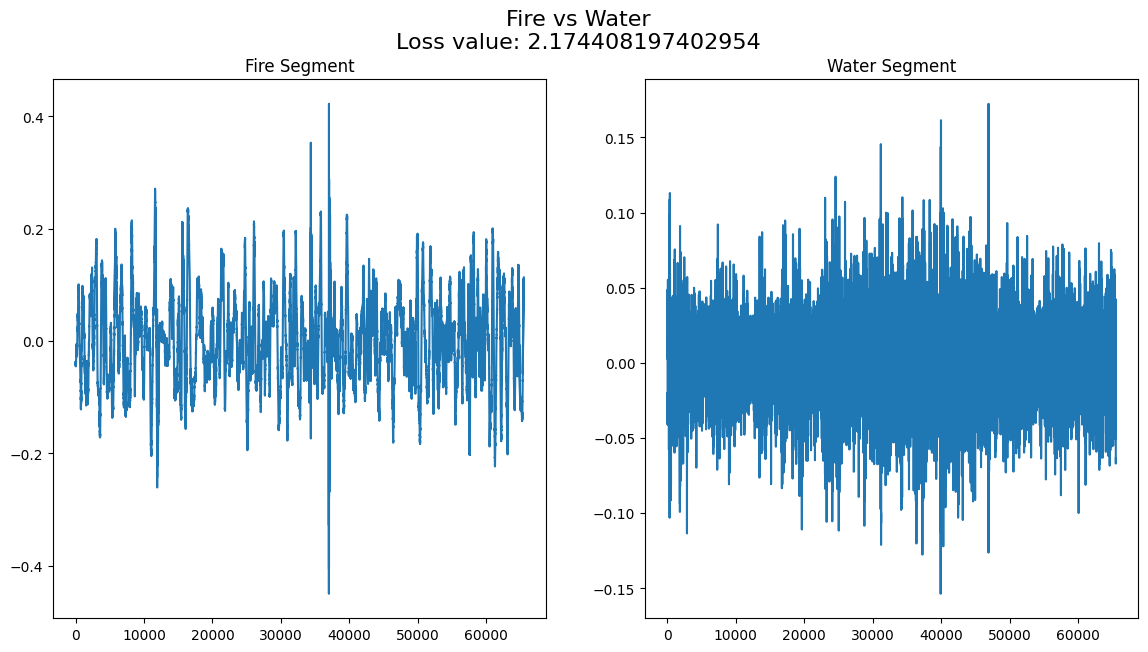

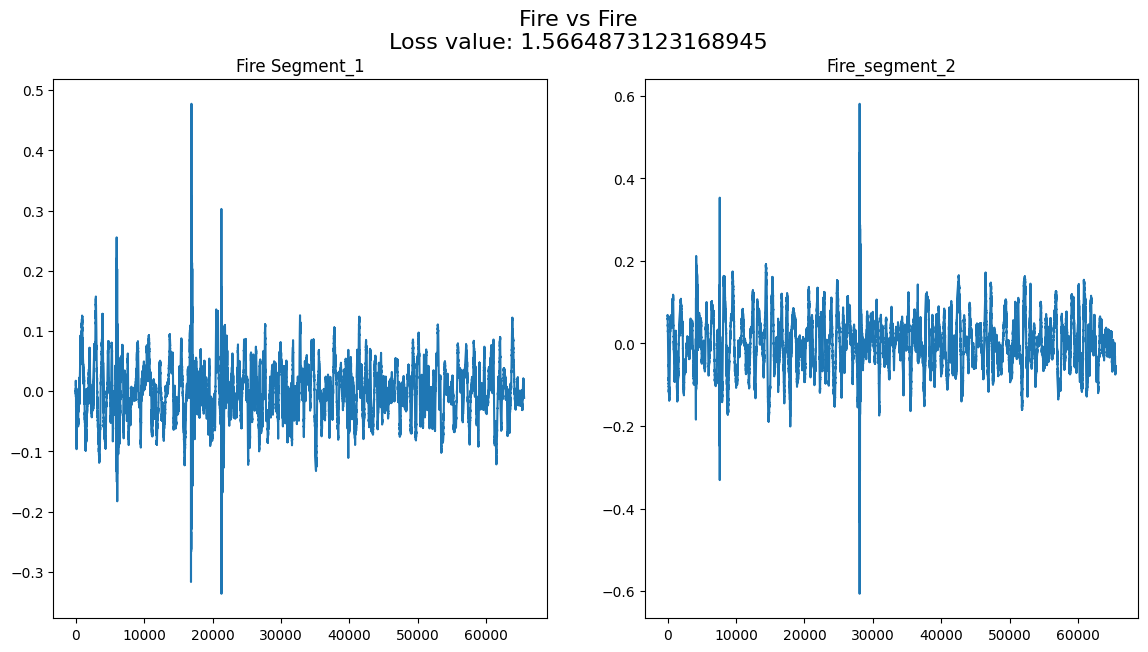

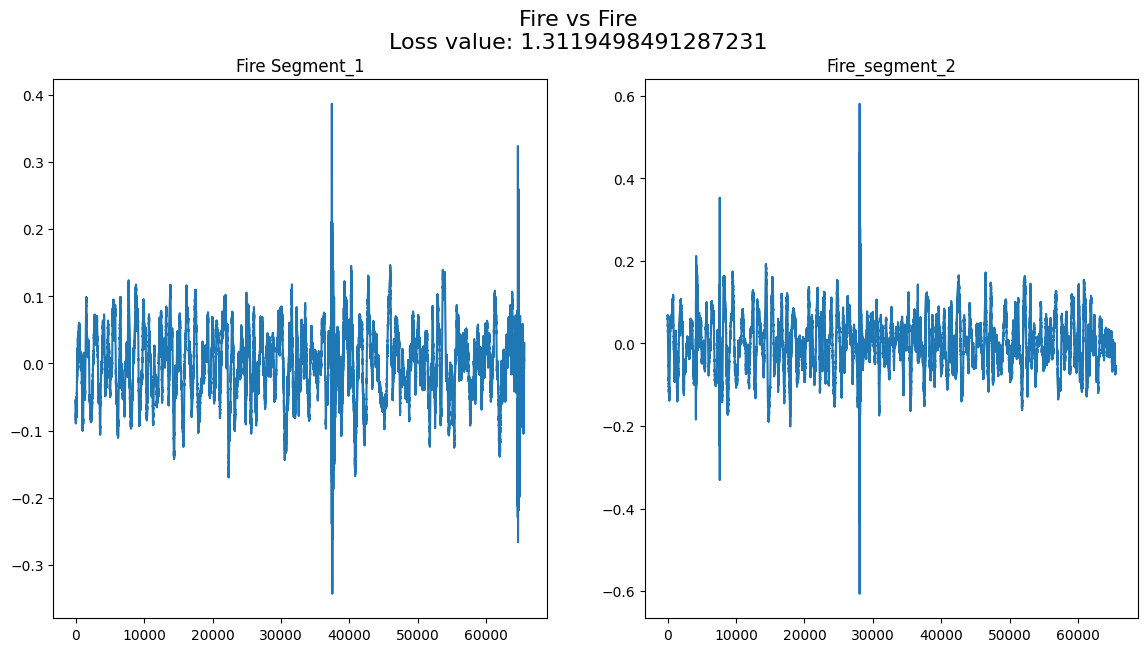

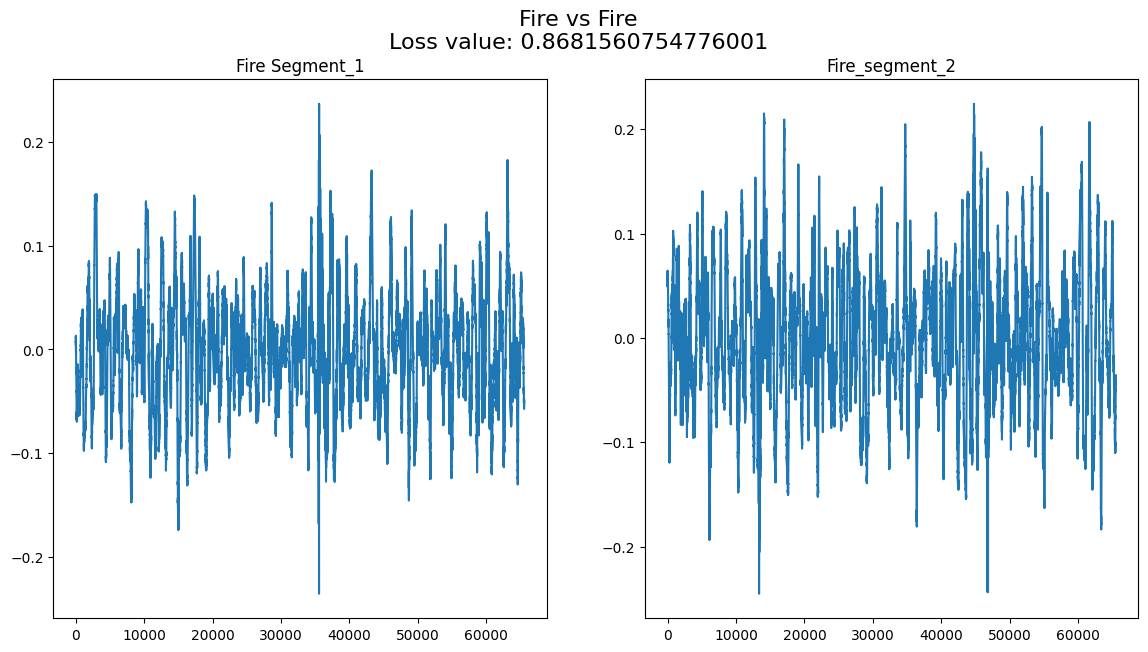

In [6]:
# Test Statistics loss function on three random pair of segments and plot them
for i in range(3):
    fire_segment  = fire_segments[np.random.randint(len(fire_segments))]
    water_segment = water_segments[np.random.randint(len(water_segments))]
    fire_segment  = torch.tensor(fire_segment)
    #play water and fire segments
    display(Audio(fire_segment, rate=sr))
    display(Audio(water_segment, rate=sr))
    water_segment = torch.tensor(water_segment)
    loss_value = ddsp_textures.loss.functions.statistics_loss(fire_segment, water_segment, 16, 44100, erb_bank, log_bank)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
    ax1.plot(fire_segment)
    ax1.set_title('Fire Segment')
    ax2.plot(water_segment)
    ax2.set_title('Water Segment')
    fig.suptitle(f'Fire vs Water\nLoss value: {loss_value}', fontsize=16)
    plt.show()
# Test Statistics loss function on three random pair of fair
for i in range(3):
    fire_segment_1 = fire_segments[np.random.randint(len(fire_segments))]
    fire_segment_2 = fire_segments[np.random.randint(len(fire_segments))]
    fire_segment_1 = torch.tensor(fire_segment_1)
    fire_segment_2 = torch.tensor(fire_segment_2)
    #play water and fire segments
    display(Audio(fire_segment_1, rate=sr))
    display(Audio(fire_segment_2, rate=sr))
    loss_value = ddsp_textures.loss.functions.statistics_loss(fire_segment_1, fire_segment_2, 16, 44100, erb_bank, log_bank)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
    ax1.plot(fire_segment_1)
    ax1.set_title('Fire Segment_1')
    ax2.plot(fire_segment_2)
    ax2.set_title('Fire_segment_2')
    fig.suptitle(f'Fire vs Fire\nLoss value: {loss_value}', fontsize=16)
    plt.show()